In [1]:
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add project root to sys.path
sys.path.append(os.path.abspath("../src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from xgboost import XGBRegressor, XGBClassifier

# Metrics
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error,
                             accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             roc_curve)

# Model interpretation
import shap

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
print("\n[1/7] Loading data...\n")

from data_loader import load_data
from cleaning import clean_data
from preprocessing import preprocess_for_analysis

# Load data
df = load_data(filename="clean_data.csv", sep=",")

# Create necessary columns
if 'margin' not in df.columns:
    df['margin'] = df['totalpremium'] - df['totalclaims']

if 'has_claim' not in df.columns:
    df['has_claim'] = (df['totalclaims'] > 0).astype(int)
df.head()


[1/7] Loading data...



,underwrittencoverid,policyid,transactionmonth,isvatregistered,citizenship,legaltype,title,language,bank,accounttype,...,covergroup,section,product,statutoryclass,statutoryrisktype,totalpremium,totalclaims,lossratio,has_claim,margin
0,145249,12827,2015-03-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0,0.0,0,21.929825
1,145249,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0,0.0,0,21.929825
2,145249,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0,0.0,0,0.000000
3,145255,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0,0.0,0,512.848070
4,145255,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0,0.0,0,0.000000


In [3]:
print("\n[2/7] Feature Engineering...\n")

df_model = df.copy()

# Calculate vehicle age
df_model['vehicle_age'] = 2015 - df_model['registrationyear']
df_model['vehicle_age'] = df_model['vehicle_age'].clip(lower=0, upper=50)

# Create risk score based on vehicle characteristics
df_model['power_ratio'] = df_model['kilowatts'] / (df_model['cubiccapacity'] + 1)

# Calculate claim rate by province
province_claim_rate = df_model.groupby('province')['has_claim'].mean()
df_model['province_risk'] = df_model['province'].map(province_claim_rate)

# Calculate claim rate by postal code
zipcode_claim_rate = df_model.groupby('postalcode')['has_claim'].mean()
df_model['zipcode_risk'] = df_model['postalcode'].map(zipcode_claim_rate)

# Premium to sum insured ratio
df_model['premium_to_sum_ratio'] = df_model['totalpremium'] / (df_model['suminsured'] + 1)

# Binary features
df_model['has_alarm'] = (df_model['alarmimmobiliser'] == 'Yes').astype(int)
df_model['has_tracking'] = (df_model['trackingdevice'] == 'Yes').astype(int)

print("âœ“ Created derived features:")
print("  - vehicle_age, power_ratio")
print("  - province_risk, zipcode_risk")
print("  - premium_to_sum_ratio")
print("  - has_alarm, has_tracking")


[2/7] Feature Engineering...

âœ“ Created derived features:
  - vehicle_age, power_ratio
  - province_risk, zipcode_risk
  - premium_to_sum_ratio
  - has_alarm, has_tracking


In [4]:
print("\n[3/7] Preparing data for modeling...\n")

# Select features for modeling
numerical_features = [
    'vehicle_age', 'cylinders', 'cubiccapacity', 'kilowatts', 
    'numberofdoors', 'suminsured', 'calculatedpremiumperterm',
    'power_ratio', 'province_risk', 'zipcode_risk', 
    'premium_to_sum_ratio'
]

categorical_features = [
    'gender', 'province', 'vehicletype', 'make', 
    'covertype', 'covercategory', 'product',
    'has_alarm', 'has_tracking'
]

# Filter features that exist
numerical_features = [f for f in numerical_features if f in df_model.columns]
categorical_features = [f for f in categorical_features if f in df_model.columns]

print(f"âœ“ Selected {len(numerical_features)} numerical features")
print(f"âœ“ Selected {len(categorical_features)} categorical features")

# Handle categorical features with too many unique values
for col in categorical_features[:]:
    if col in df_model.columns:
        n_unique = df_model[col].nunique()
        if n_unique > 50:  # Too many categories
            print(f"  âš  Removing {col} - too many categories ({n_unique})")
            categorical_features.remove(col)

# Prepare preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("\nâœ“ Preprocessing pipeline created")


[3/7] Preparing data for modeling...

âœ“ Selected 11 numerical features
âœ“ Selected 9 categorical features

âœ“ Preprocessing pipeline created


In [5]:
print("\n" + "="*80)
print("MODEL 1: CLAIM SEVERITY PREDICTION")
print("="*80)
print("\nTarget: TotalClaims (for policies where claims > 0)")
print("Objective: Predict financial liability for risky policies")
print("Metric: RMSE, RÂ²\n")

# Filter to only policies with claims
df_claims = df_model[df_model['totalclaims'] > 0].copy()
print(f"Dataset size: {len(df_claims):,} policies with claims")

# Prepare features and target
X_claims = df_claims[numerical_features + categorical_features]
y_claims = df_claims['totalclaims']

# Train-test split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_claims, y_claims, test_size=0.2, random_state=42
)

print(f"Training set: {len(X_train_c):,} samples")
print(f"Test set: {len(X_test_c):,} samples")

# Preprocess data
X_train_c_processed = preprocessor.fit_transform(X_train_c)
X_test_c_processed = preprocessor.transform(X_test_c)
feature_names_severity = preprocessor.get_feature_names_out().tolist()
print("\n--- Training Models ---\n")

# Dictionary to store results
severity_results = {}

# Model 1: Linear Regression
print("1. Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train_c_processed, y_train_c)
y_pred_lr = lr_model.predict(X_test_c_processed)

severity_results['Linear Regression'] = {
    'model': lr_model,
    'rmse': np.sqrt(mean_squared_error(y_test_c, y_pred_lr)),
    'r2': r2_score(y_test_c, y_pred_lr),
    'mae': mean_absolute_error(y_test_c, y_pred_lr),
    'predictions': y_pred_lr
}
print(f"   RMSE: R{severity_results['Linear Regression']['rmse']:,.2f}")
print(f"   RÂ²: {severity_results['Linear Regression']['r2']:.4f}")



MODEL 1: CLAIM SEVERITY PREDICTION

Target: TotalClaims (for policies where claims > 0)
Objective: Predict financial liability for risky policies
Metric: RMSE, RÂ²

Dataset size: 2,788 policies with claims
Training set: 2,230 samples
Test set: 558 samples

--- Training Models ---

1. Linear Regression...
   RMSE: R33,914.71
   RÂ²: 0.2848


In [6]:
print("\n2. Decision Tree...")
dt_model = DecisionTreeRegressor(max_depth=10, min_samples_split=50, random_state=42)
dt_model.fit(X_train_c_processed, y_train_c)
y_pred_dt = dt_model.predict(X_test_c_processed)

severity_results['Decision Tree'] = {
    'model': dt_model,
    'rmse': np.sqrt(mean_squared_error(y_test_c, y_pred_dt)),
    'r2': r2_score(y_test_c, y_pred_dt),
    'mae': mean_absolute_error(y_test_c, y_pred_dt),
    'predictions': y_pred_dt
}
print(f"   RMSE: R{severity_results['Decision Tree']['rmse']:,.2f}")
print(f"   RÂ²: {severity_results['Decision Tree']['r2']:.4f}")


2. Decision Tree...
   RMSE: R35,521.92
   RÂ²: 0.2154


In [7]:
print("\n3. Random Forest...")
rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, 
                                 min_samples_split=50, random_state=42, n_jobs=-1)
rf_model.fit(X_train_c_processed, y_train_c)
y_pred_rf = rf_model.predict(X_test_c_processed)

severity_results['Random Forest'] = {
    'model': rf_model,
    'rmse': np.sqrt(mean_squared_error(y_test_c, y_pred_rf)),
    'r2': r2_score(y_test_c, y_pred_rf),
    'mae': mean_absolute_error(y_test_c, y_pred_rf),
    'predictions': y_pred_rf
}
print(f"   RMSE: R{severity_results['Random Forest']['rmse']:,.2f}")
print(f"   RÂ²: {severity_results['Random Forest']['r2']:.4f}")


3. Random Forest...
   RMSE: R34,080.33
   RÂ²: 0.2778


In [8]:
print("\n4. XGBoost...")
xgb_model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1,
                        random_state=42, n_jobs=-1)
xgb_model.fit(X_train_c_processed, y_train_c)
y_pred_xgb = y_pred_xgb = xgb_model.predict(X_test_c_processed)

severity_results['XGBoost'] = {
    'model': xgb_model,
    'rmse': np.sqrt(mean_squared_error(y_test_c, y_pred_xgb)),
    'r2': r2_score(y_test_c, y_pred_xgb),
    'mae': mean_absolute_error(y_test_c, y_pred_xgb),
    'predictions': y_pred_xgb
}
print(f"   RMSE: R{severity_results['XGBoost']['rmse']:,.2f}")
print(f"   RÂ²: {severity_results['XGBoost']['r2']:.4f}")


4. XGBoost...
   RMSE: R38,254.98
   RÂ²: 0.0900



--------------------------------------------------------------------------------
CLAIM SEVERITY MODEL COMPARISON
--------------------------------------------------------------------------------
            Model         RMSE      RÂ²          MAE
Linear Regression 33914.706295 0.284807 17380.392077
    Decision Tree 35521.920060 0.215415 15982.245922
    Random Forest 34080.331765 0.277805 15821.285692
          XGBoost 38254.983933 0.090038 17047.243237

âœ“ Best Model: Linear Regression (Lowest RMSE)


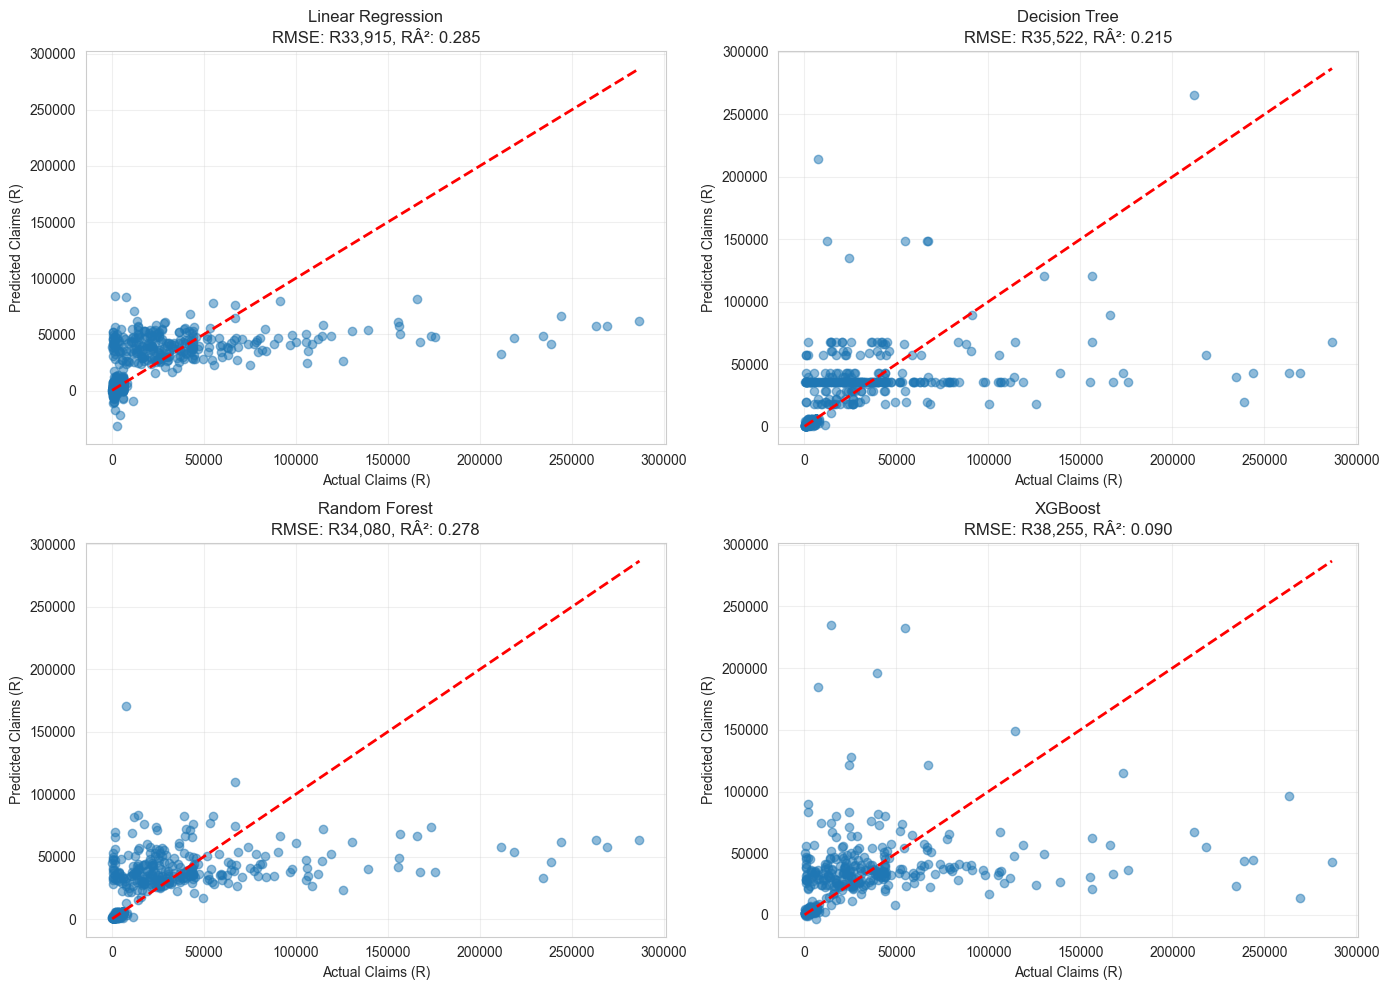

In [9]:
print("\n" + "-"*80)
print("CLAIM SEVERITY MODEL COMPARISON")
print("-"*80)

comparison_df = pd.DataFrame({
    'Model': severity_results.keys(),
    'RMSE': [v['rmse'] for v in severity_results.values()],
    'RÂ²': [v['r2'] for v in severity_results.values()],
    'MAE': [v['mae'] for v in severity_results.values()]
})

print(comparison_df.to_string(index=False))

# Best model
best_severity_model = min(severity_results.items(), key=lambda x: x[1]['rmse'])
print(f"\nâœ“ Best Model: {best_severity_model[0]} (Lowest RMSE)")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, (name, results) in enumerate(severity_results.items()):
    row = idx // 2
    col = idx % 2
    
    axes[row, col].scatter(y_test_c, results['predictions'], alpha=0.5)
    axes[row, col].plot([y_test_c.min(), y_test_c.max()], 
                        [y_test_c.min(), y_test_c.max()], 
                        'r--', lw=2)
    axes[row, col].set_xlabel('Actual Claims (R)')
    axes[row, col].set_ylabel('Predicted Claims (R)')
    axes[row, col].set_title(f'{name}\nRMSE: R{results["rmse"]:,.0f}, RÂ²: {results["r2"]:.3f}')
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('claim_severity_predictions.png', dpi=300, bbox_inches='tight')
plt.show()


MODEL 2: CLAIM PROBABILITY PREDICTION

Target: Has_Claim (Binary: 0 or 1)
Objective: Predict probability of a claim occurring
Metrics: Accuracy, Precision, Recall, F1, ROC-AUC

Dataset size: 1,000,098 policies
Positive class (claims): 2,788 (0.28%)
Negative class (no claims): 997,310

Training set: 800,078 samples
Test set: 200,020 samples

--- Training Models ---

1. Logistic Regression...
   ROC-AUC: 0.9162
   F1 Score: 0.0242

2. Decision Tree...
   ROC-AUC: 0.9047
   F1 Score: 0.0319

3. Random Forest...
   ROC-AUC: 0.9307
   F1 Score: 0.0352

4. XGBoost...
   ROC-AUC: 0.9341
   F1 Score: 0.0338

--------------------------------------------------------------------------------
CLAIM PROBABILITY MODEL COMPARISON
--------------------------------------------------------------------------------
              Model  Accuracy  Precision   Recall       F1  ROC-AUC
Logistic Regression  0.783907   0.012233 0.958781 0.024157 0.916153
      Decision Tree  0.846050   0.016225 0.908602 0.031880

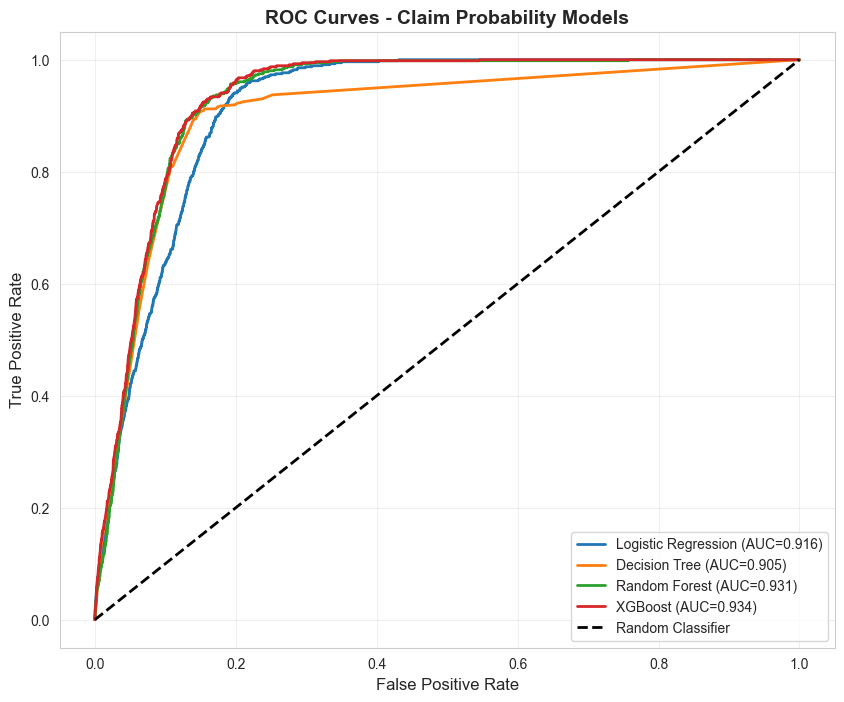

In [10]:
print("\n" + "="*80)
print("MODEL 2: CLAIM PROBABILITY PREDICTION")
print("="*80)
print("\nTarget: Has_Claim (Binary: 0 or 1)")
print("Objective: Predict probability of a claim occurring")
print("Metrics: Accuracy, Precision, Recall, F1, ROC-AUC\n")

# Prepare features and target for full dataset
X_prob = df_model[numerical_features + categorical_features]
y_prob = df_model['has_claim']

print(f"Dataset size: {len(df_model):,} policies")
print(f"Positive class (claims): {y_prob.sum():,} ({y_prob.mean()*100:.2f}%)")
print(f"Negative class (no claims): {(~y_prob.astype(bool)).sum():,}")

# Train-test split
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    X_prob, y_prob, test_size=0.2, random_state=42, stratify=y_prob
)

print(f"\nTraining set: {len(X_train_p):,} samples")
print(f"Test set: {len(X_test_p):,} samples")

# Preprocess data (use same preprocessor but refit on full data)
preprocessor_prob = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train_p_processed = preprocessor_prob.fit_transform(X_train_p)
X_test_p_processed = preprocessor_prob.transform(X_test_p)
feature_names_prob = preprocessor_prob.get_feature_names_out().tolist()
print("\n--- Training Models ---\n")

# Dictionary to store results
probability_results = {}

# Model 1: Logistic Regression
print("1. Logistic Regression...")
log_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
log_model.fit(X_train_p_processed, y_train_p)
y_pred_log = log_model.predict(X_test_p_processed)
y_proba_log = log_model.predict_proba(X_test_p_processed)[:, 1]

probability_results['Logistic Regression'] = {
    'model': log_model,
    'accuracy': accuracy_score(y_test_p, y_pred_log),
    'precision': precision_score(y_test_p, y_pred_log, zero_division=0),
    'recall': recall_score(y_test_p, y_pred_log),
    'f1': f1_score(y_test_p, y_pred_log),
    'roc_auc': roc_auc_score(y_test_p, y_proba_log),
    'predictions': y_pred_log,
    'probabilities': y_proba_log
}
print(f"   ROC-AUC: {probability_results['Logistic Regression']['roc_auc']:.4f}")
print(f"   F1 Score: {probability_results['Logistic Regression']['f1']:.4f}")

# Model 2: Decision Tree
print("\n2. Decision Tree...")
dt_clf = DecisionTreeClassifier(max_depth=10, min_samples_split=100, 
                                random_state=42, class_weight='balanced')
dt_clf.fit(X_train_p_processed, y_train_p)
y_pred_dt_clf = dt_clf.predict(X_test_p_processed)
y_proba_dt_clf = dt_clf.predict_proba(X_test_p_processed)[:, 1]

probability_results['Decision Tree'] = {
    'model': dt_clf,
    'accuracy': accuracy_score(y_test_p, y_pred_dt_clf),
    'precision': precision_score(y_test_p, y_pred_dt_clf, zero_division=0),
    'recall': recall_score(y_test_p, y_pred_dt_clf),
    'f1': f1_score(y_test_p, y_pred_dt_clf),
    'roc_auc': roc_auc_score(y_test_p, y_proba_dt_clf),
    'predictions': y_pred_dt_clf,
    'probabilities': y_proba_dt_clf
}
print(f"   ROC-AUC: {probability_results['Decision Tree']['roc_auc']:.4f}")
print(f"   F1 Score: {probability_results['Decision Tree']['f1']:.4f}")

# Model 3: Random Forest
print("\n3. Random Forest...")
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=15, 
                                min_samples_split=100, random_state=42, 
                                class_weight='balanced', n_jobs=-1)
rf_clf.fit(X_train_p_processed, y_train_p)
y_pred_rf_clf = rf_clf.predict(X_test_p_processed)
y_proba_rf_clf = rf_clf.predict_proba(X_test_p_processed)[:, 1]

probability_results['Random Forest'] = {
    'model': rf_clf,
    'accuracy': accuracy_score(y_test_p, y_pred_rf_clf),
    'precision': precision_score(y_test_p, y_pred_rf_clf, zero_division=0),
    'recall': recall_score(y_test_p, y_pred_rf_clf),
    'f1': f1_score(y_test_p, y_pred_rf_clf),
    'roc_auc': roc_auc_score(y_test_p, y_proba_rf_clf),
    'predictions': y_pred_rf_clf,
    'probabilities': y_proba_rf_clf
}
print(f"   ROC-AUC: {probability_results['Random Forest']['roc_auc']:.4f}")
print(f"   F1 Score: {probability_results['Random Forest']['f1']:.4f}")

# Model 4: XGBoost
print("\n4. XGBoost...")
scale_pos_weight = (y_train_p == 0).sum() / (y_train_p == 1).sum()
xgb_clf = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                       scale_pos_weight=scale_pos_weight, random_state=42, n_jobs=-1)
xgb_clf.fit(X_train_p_processed, y_train_p)
y_pred_xgb_clf = xgb_clf.predict(X_test_p_processed)
y_proba_xgb_clf = xgb_clf.predict_proba(X_test_p_processed)[:, 1]

probability_results['XGBoost'] = {
    'model': xgb_clf,
    'accuracy': accuracy_score(y_test_p, y_pred_xgb_clf),
    'precision': precision_score(y_test_p, y_pred_xgb_clf, zero_division=0),
    'recall': recall_score(y_test_p, y_pred_xgb_clf),
    'f1': f1_score(y_test_p, y_pred_xgb_clf),
    'roc_auc': roc_auc_score(y_test_p, y_proba_xgb_clf),
    'predictions': y_pred_xgb_clf,
    'probabilities': y_proba_xgb_clf
}
print(f"   ROC-AUC: {probability_results['XGBoost']['roc_auc']:.4f}")
print(f"   F1 Score: {probability_results['XGBoost']['f1']:.4f}")

# Compare models
print("\n" + "-"*80)
print("CLAIM PROBABILITY MODEL COMPARISON")
print("-"*80)

comparison_prob_df = pd.DataFrame({
    'Model': probability_results.keys(),
    'Accuracy': [v['accuracy'] for v in probability_results.values()],
    'Precision': [v['precision'] for v in probability_results.values()],
    'Recall': [v['recall'] for v in probability_results.values()],
    'F1': [v['f1'] for v in probability_results.values()],
    'ROC-AUC': [v['roc_auc'] for v in probability_results.values()]
})

print(comparison_prob_df.to_string(index=False))

# Best model
best_prob_model = max(probability_results.items(), key=lambda x: x[1]['roc_auc'])
print(f"\nâœ“ Best Model: {best_prob_model[0]} (Highest ROC-AUC)")

# ROC Curves
plt.figure(figsize=(10, 8))
for name, results in probability_results.items():
    fpr, tpr, _ = roc_curve(y_test_p, results['probabilities'])
    plt.plot(fpr, tpr, label=f"{name} (AUC={results['roc_auc']:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Claim Probability Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.savefig('claim_probability_roc.png', dpi=300, bbox_inches='tight')
plt.show()


In [11]:
print("\n" + "="*80)
print("MODEL 3: PREMIUM OPTIMIZATION")
print("="*80)
print("\nTarget: CalculatedPremiumPerTerm")
print("Objective: Predict optimal premium based on risk factors")
print("Metrics: RMSE, RÂ², MAE\n")

# Prepare features and target
X_premium = df_model[numerical_features + categorical_features]
y_premium = df_model['calculatedpremiumperterm']

# Remove premium-related features from predictors
premium_features_to_remove = ['calculatedpremiumperterm', 'premium_to_sum_ratio']
num_feats_prem = [f for f in numerical_features if f not in premium_features_to_remove]

X_premium = df_model[num_feats_prem + categorical_features]

print(f"Dataset size: {len(df_model):,} policies")

# Train-test split
X_train_pr, X_test_pr, y_train_pr, y_test_pr = train_test_split(
    X_premium, y_premium, test_size=0.2, random_state=42
)

# Preprocess
preprocessor_prem = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_feats_prem),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train_pr_processed = preprocessor_prem.fit_transform(X_train_pr)
X_test_pr_processed = preprocessor_prem.transform(X_test_pr)
feature_names_prem = preprocessor_prem.get_feature_names_out().tolist()
print(f"Training set: {len(X_train_pr):,} samples")
print(f"Test set: {len(X_test_pr):,} samples")

print("\n--- Training Models ---\n")

# Dictionary to store results
premium_results = {}

# Model 1: Linear Regression
print("1. Linear Regression...")
lr_prem = LinearRegression()
lr_prem.fit(X_train_pr_processed, y_train_pr)
y_pred_lr_prem = lr_prem.predict(X_test_pr_processed)

premium_results['Linear Regression'] = {
    'model': lr_prem,
    'rmse': np.sqrt(mean_squared_error(y_test_pr, y_pred_lr_prem)),
    'r2': r2_score(y_test_pr, y_pred_lr_prem),
    'mae': mean_absolute_error(y_test_pr, y_pred_lr_prem),
    'predictions': y_pred_lr_prem
}
print(f"   RMSE: R{premium_results['Linear Regression']['rmse']:,.2f}")
print(f"   RÂ²: {premium_results['Linear Regression']['r2']:.4f}")

# Model 2: Random Forest
print("\n2. Random Forest...")
rf_prem = RandomForestRegressor(n_estimators=100, max_depth=15, 
                                min_samples_split=50, random_state=42, n_jobs=-1)
rf_prem.fit(X_train_pr_processed, y_train_pr)
y_pred_rf_prem = rf_prem.predict(X_test_pr_processed)

premium_results['Random Forest'] = {
    'model': rf_prem,
    'rmse': np.sqrt(mean_squared_error(y_test_pr, y_pred_rf_prem)),
    'r2': r2_score(y_test_pr, y_pred_rf_prem),
    'mae': mean_absolute_error(y_test_pr, y_pred_rf_prem),
    'predictions': y_pred_rf_prem
}
print(f"   RMSE: R{premium_results['Random Forest']['rmse']:,.2f}")
print(f"   RÂ²: {premium_results['Random Forest']['r2']:.4f}")

# Model 3: XGBoost
print("\n3. XGBoost...")
xgb_prem = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1,
                       random_state=42, n_jobs=-1)
xgb_prem.fit(X_train_pr_processed, y_train_pr)
y_pred_xgb_prem = xgb_prem.predict(X_test_pr_processed)

premium_results['XGBoost'] = {
    'model': xgb_prem,
    'rmse': np.sqrt(mean_squared_error(y_test_pr, y_pred_xgb_prem)),
    'r2': r2_score(y_test_pr, y_pred_xgb_prem),
    'mae': mean_absolute_error(y_test_pr, y_pred_xgb_prem),
    'predictions': y_pred_xgb_prem
}
print(f"   RMSE: R{premium_results['XGBoost']['rmse']:,.2f}")
print(f"   RÂ²: {premium_results['XGBoost']['r2']:.4f}")

# Compare models
print("\n" + "-"*80)
print("PREMIUM OPTIMIZATION MODEL COMPARISON")
print("-"*80)

comparison_prem_df = pd.DataFrame({
    'Model': premium_results.keys(),
    'RMSE': [v['rmse'] for v in premium_results.values()],
    'RÂ²': [v['r2'] for v in premium_results.values()],
    'MAE': [v['mae'] for v in premium_results.values()]
})

print(comparison_prem_df.to_string(index=False))

best_premium_model = min(premium_results.items(), key=lambda x: x[1]['rmse'])
print(f"\nâœ“ Best Model: {best_premium_model[0]} (Lowest RMSE)")



MODEL 3: PREMIUM OPTIMIZATION

Target: CalculatedPremiumPerTerm
Objective: Predict optimal premium based on risk factors
Metrics: RMSE, RÂ², MAE

Dataset size: 1,000,098 policies
Training set: 800,078 samples
Test set: 200,020 samples

--- Training Models ---

1. Linear Regression...
   RMSE: R207.97
   RÂ²: 0.4582

2. Random Forest...
   RMSE: R29.71
   RÂ²: 0.9889

3. XGBoost...
   RMSE: R36.56
   RÂ²: 0.9833

--------------------------------------------------------------------------------
PREMIUM OPTIMIZATION MODEL COMPARISON
--------------------------------------------------------------------------------
            Model       RMSE      RÂ²       MAE
Linear Regression 207.971922 0.458187 41.489539
    Random Forest  29.706344 0.988946  8.645219
          XGBoost  36.557160 0.983259 11.832682

âœ“ Best Model: Random Forest (Lowest RMSE)



[4/7] FEATURE IMPORTANCE & INTERPRETABILITY

Analyzing feature importance for best models:
  - Claim Severity: Linear Regression
  - Claim Probability: XGBoost
  - Premium Optimization: Random Forest

--- SHAP Analysis: Claim Severity ---
Note: Linear Regression is not tree-based. Using coefficient analysis instead of SHAP.

Top 10 Most Important Features (by Absolute Coefficient):
                                      Feature   Coefficient  Abs_Coefficient
                           cat__make_POLARSUN  87739.425878     87739.425878
                            cat__make_HYUNDAI  48951.492653     48951.492653
                            cat__make_missing -41489.997744     41489.997744
                              num__suminsured  40722.102156     40722.102156
                num__calculatedpremiumperterm -36303.610561     36303.610561
cat__make_MERCEDES-BENZ                        31022.084771     31022.084771
                              cat__make_FOTON -26702.494396     26702.49439

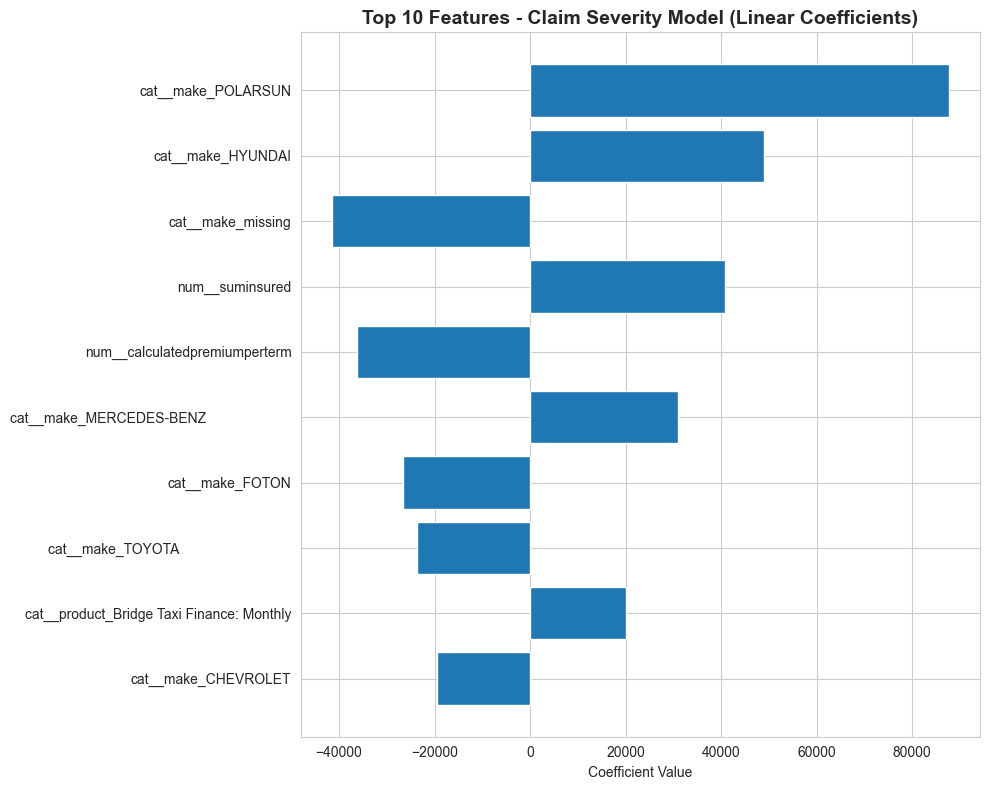


--- SHAP Analysis: Claim Probability ---
Calculating SHAP values...


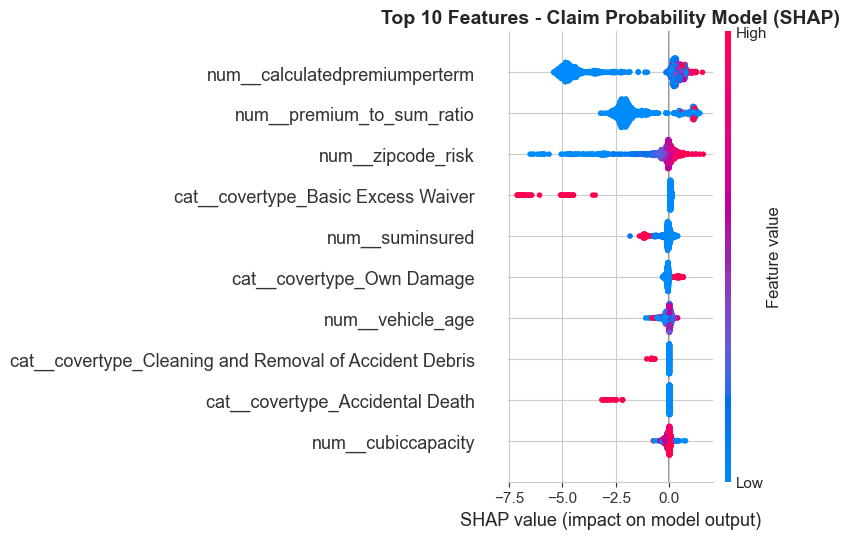


Top 10 Most Important Features (Claim Probability):
                                  Feature  Importance
                num__premium_to_sum_ratio    0.194700
       cat__covertype_Basic Excess Waiver    0.150661
            num__calculatedpremiumperterm    0.038783
                cat__covertype_Own Damage    0.034649
          cat__covertype_Income Protector    0.024955
                        num__zipcode_risk    0.022662
cat__product_Bridge Taxi Finance: Monthly    0.019720
                cat__covertype_Windscreen    0.018205
          cat__covertype_Accidental Death    0.017099
            cat__covercategory_Windscreen    0.016996

âœ“ Feature importance analysis complete. Plots saved.


In [12]:
print("\n" + "="*80)
print("[4/7] FEATURE IMPORTANCE & INTERPRETABILITY")
print("="*80)

# Use best model from each task for SHAP analysis
if best_severity_model and len(best_severity_model) > 0:
    best_severity_model_obj = severity_results[best_severity_model[0]]['model']
else:
    raise ValueError("best_severity_model is empty or invalid.")

if best_prob_model and len(best_prob_model) > 0:
    best_prob_model_obj = probability_results[best_prob_model[0]]['model']
else:
    raise ValueError("best_prob_model is empty or invalid.")

if best_premium_model and len(best_premium_model) > 0:
    best_premium_model_obj = premium_results[best_premium_model[0]]['model']
else:
    raise ValueError("best_premium_model is empty or invalid.")

print(f"\nAnalyzing feature importance for best models:")
print(f"  - Claim Severity: {best_severity_model[0]}")
print(f"  - Claim Probability: {best_prob_model[0]}")
print(f"  - Premium Optimization: {best_premium_model[0]}")

# SHAP Analysis for Claim Severity Model
print("\n--- SHAP Analysis: Claim Severity ---")

# Get feature names
feature_names = feature_names_severity 
# Use probability-specific feature names when available
feature_names_prob_used = feature_names_prob if 'feature_names_prob' in globals() else feature_names

# Check if model is tree-based (SHAP TreeExplainer only works with tree models)
is_tree_based_severity = hasattr(best_severity_model_obj, 'feature_importances_')

if is_tree_based_severity:
    print("Calculating SHAP values (this may take a few minutes)...")
    
    # Use a sample for SHAP to speed up computation
    sample_size = min(1000, len(X_test_c_processed))
    X_test_sample = X_test_c_processed[:sample_size]
    
    # Create SHAP explainer for tree-based models
    explainer_severity = shap.TreeExplainer(best_severity_model_obj)
    shap_values_severity = explainer_severity.shap_values(X_test_sample)
    
    # Summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_severity, X_test_sample, 
                      feature_names=feature_names, show=False, max_display=10)
    plt.title('Top 10 Features - Claim Severity Model (SHAP)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('shap_severity.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Feature importance
    importance_df = pd.DataFrame({
        'Feature': feature_names[:len(best_severity_model_obj.feature_importances_)],
        'Importance': best_severity_model_obj.feature_importances_
    }).sort_values('Importance', ascending=False).head(10)
    
    print("\nTop 10 Most Important Features (Claim Severity):")
    print(importance_df.to_string(index=False))
    
else:
    # For Linear Regression, use coefficients as importance
    print(f"Note: {best_severity_model[0]} is not tree-based. Using coefficient analysis instead of SHAP.")
    
    if hasattr(best_severity_model_obj, 'coef_'):
        # Get absolute coefficients as importance
        coefficients = np.abs(best_severity_model_obj.coef_)
        
        # For linear models, we need to account for all features after one-hot encoding
        n_features = len(coefficients)
        feature_names_encoded = feature_names[:n_features] if n_features <= len(feature_names) else [f"feature_{i}" for i in range(n_features)]
        
        importance_df = pd.DataFrame({
            'Feature': feature_names_encoded,
            'Coefficient': best_severity_model_obj.coef_,
            'Abs_Coefficient': coefficients
        }).sort_values('Abs_Coefficient', ascending=False).head(10)
        
        print("\nTop 10 Most Important Features (by Absolute Coefficient):")
        print(importance_df[['Feature', 'Coefficient', 'Abs_Coefficient']].to_string(index=False))
        
        # Plot coefficients
        plt.figure(figsize=(10, 8))
        plt.barh(range(10), importance_df['Coefficient'].head(10)[::-1])
        plt.yticks(range(10), importance_df['Feature'].head(10)[::-1])
        plt.xlabel('Coefficient Value')
        plt.title('Top 10 Features - Claim Severity Model (Linear Coefficients)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig('shap_severity.png', dpi=300, bbox_inches='tight')
        plt.show()

# SHAP Analysis for Claim Probability Model
print("\n--- SHAP Analysis: Claim Probability ---")

is_tree_based_prob = hasattr(best_prob_model_obj, 'feature_importances_')

if is_tree_based_prob:
    print("Calculating SHAP values...")
    
    sample_size = min(1000, len(X_test_p_processed))
    X_test_prob_sample = X_test_p_processed[:sample_size]
    
    explainer_prob = shap.TreeExplainer(best_prob_model_obj)
    shap_values_prob = explainer_prob.shap_values(X_test_prob_sample)
    
    # For binary classification, use the positive class SHAP values
    if isinstance(shap_values_prob, list):
        shap_values_prob = shap_values_prob[1]
    
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_prob, X_test_prob_sample, 
                      feature_names=feature_names_prob_used, show=False, max_display=10)
    plt.title('Top 10 Features - Claim Probability Model (SHAP)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('shap_probability.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    importance_prob_df = pd.DataFrame({
        'Feature': feature_names_prob_used[:len(best_prob_model_obj.feature_importances_)],
        'Importance': best_prob_model_obj.feature_importances_
    }).sort_values('Importance', ascending=False).head(10)
    
    print("\nTop 10 Most Important Features (Claim Probability):")
    print(importance_prob_df.to_string(index=False))
    
else:
    # For Logistic Regression, use coefficients
    print(f"Note: {best_prob_model[0]} is not tree-based. Using coefficient analysis instead of SHAP.")
    
    if hasattr(best_prob_model_obj, 'coef_'):
        coefficients = np.abs(best_prob_model_obj.coef_[0])
        
        n_features = len(coefficients)
        feature_names_encoded = feature_names_prob_used[:n_features] if n_features <= len(feature_names_prob_used) else [f"feature_{i}" for i in range(n_features)]
        
        importance_prob_df = pd.DataFrame({
            'Feature': feature_names_encoded,
            'Coefficient': best_prob_model_obj.coef_[0],
            'Abs_Coefficient': coefficients
        }).sort_values('Abs_Coefficient', ascending=False).head(10)
        
        print("\nTop 10 Most Important Features (by Absolute Coefficient):")
        print(importance_prob_df[['Feature', 'Coefficient', 'Abs_Coefficient']].to_string(index=False))
        
        # Plot
        plt.figure(figsize=(10, 8))
        plt.barh(range(10), importance_prob_df['Coefficient'].head(10)[::-1])
        plt.yticks(range(10), importance_prob_df['Feature'].head(10)[::-1])
        plt.xlabel('Coefficient Value')
        plt.title('Top 10 Features - Claim Probability Model (Logistic Coefficients)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig('shap_probability.png', dpi=300, bbox_inches='tight')
        plt.show()

print("\nâœ“ Feature importance analysis complete. Plots saved.")


[5/7] RISK-BASED PREMIUM FRAMEWORK

Formula: Premium = (P(Claim) Ã— Expected Severity) + Expense + Profit

Risk-Based Premium Statistics:
Mean Actual Premium: R61.60
Mean Risk-Based Premium: R4,499.25
Mean Difference: R4,437.65
Median % Difference: 6507.54%


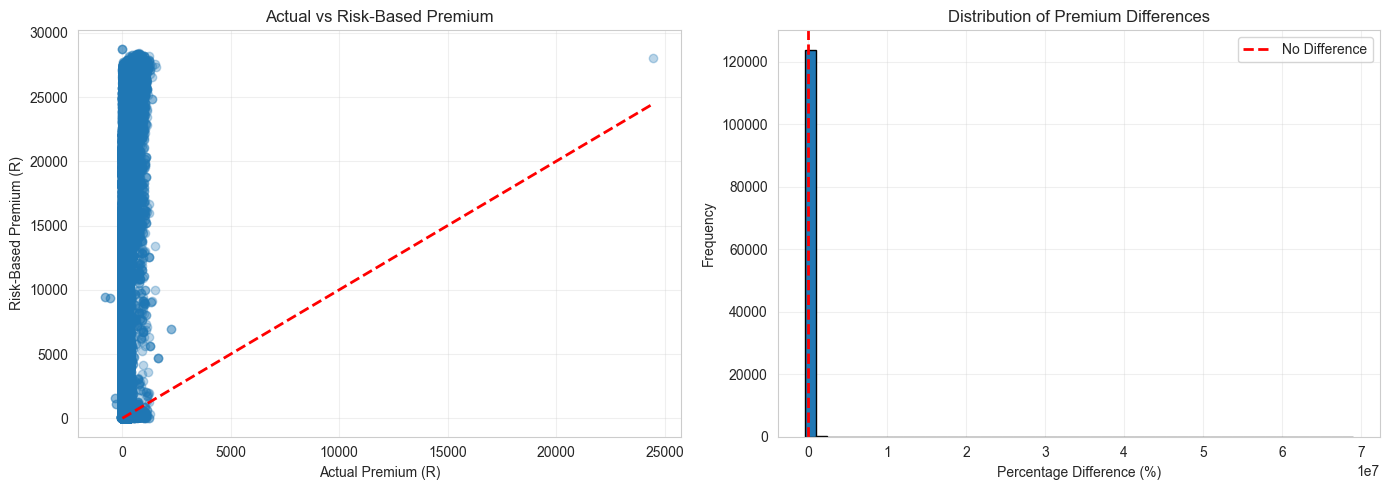

In [23]:
print("\n" + "="*80)
print("[5/7] RISK-BASED PREMIUM FRAMEWORK")
print("="*80)
print("\nFormula: Premium = (P(Claim) Ã— Expected Severity) + Expense + Profit")

# Get predictions on test set
claim_prob_test = probability_results[best_prob_model[0]]['probabilities']
claim_severity_test = severity_results[best_severity_model[0]]['predictions']

# Calculate risk-based premium
# Expected Loss = Probability of Claim Ã— Expected Claim Amount
# For policies without claims in test set, we need to impute expected severity
# Use mean severity from training data
mean_severity = y_train_c.mean()

# Map test indices to full dataframe
test_indices = X_test_p.index

# Create risk score
risk_score = claim_prob_test * mean_severity

# Add expense loading (e.g., 15% of expected loss for administrative costs)
expense_loading = 0.15
profit_margin = 0.10

risk_based_premium = risk_score * (1 + expense_loading + profit_margin)

# Compare with actual premiums
actual_premium_test = df_model.loc[test_indices, 'totalpremium'].values

comparison_premium = pd.DataFrame({
    'Actual_Premium': actual_premium_test,
    'Risk_Based_Premium': risk_based_premium,
    'Difference': risk_based_premium - actual_premium_test,
    'Pct_Difference': ((risk_based_premium - actual_premium_test) / actual_premium_test) * 100
})

print("\nRisk-Based Premium Statistics:")
print(f"Mean Actual Premium: R{comparison_premium['Actual_Premium'].mean():,.2f}")
print(f"Mean Risk-Based Premium: R{comparison_premium['Risk_Based_Premium'].mean():,.2f}")
print(f"Mean Difference: R{comparison_premium['Difference'].mean():,.2f}")
print(f"Median % Difference: {comparison_premium['Pct_Difference'].median():.2f}%")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(comparison_premium['Actual_Premium'], 
                comparison_premium['Risk_Based_Premium'], alpha=0.3)
axes[0].plot([0, comparison_premium['Actual_Premium'].max()], 
             [0, comparison_premium['Actual_Premium'].max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Premium (R)')
axes[0].set_ylabel('Risk-Based Premium (R)')
axes[0].set_title('Actual vs Risk-Based Premium')
axes[0].grid(True, alpha=0.3)

# Handle infinite values in Pct_Difference
comparison_premium['Pct_Difference'].replace([np.inf, -np.inf], np.nan, inplace=True)
comparison_premium.dropna(subset=['Pct_Difference'], inplace=True)

axes[1].hist(comparison_premium['Pct_Difference'], bins=50, edgecolor='black')
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='No Difference')
axes[1].set_xlabel('Percentage Difference (%)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Premium Differences')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('risk_based_premium_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [24]:
print("\n" + "="*80)
print("[6/7] BUSINESS INSIGHTS & RECOMMENDATIONS")
print("="*80)

print("\n1. MODEL PERFORMANCE SUMMARY:")
print(f"   â€¢ Claim Severity: {best_severity_model[0]} achieves RÂ² of {best_severity_model[1]['r2']:.3f}")
print(f"   â€¢ Claim Probability: {best_prob_model[0]} achieves ROC-AUC of {best_prob_model[1]['roc_auc']:.3f}")
print(f"   â€¢ Premium Optimization: {best_premium_model[0]} achieves RÂ² of {best_premium_model[1]['r2']:.3f}")

print("\n2. KEY RISK DRIVERS (Top Features):")
if is_tree_based_severity and 'importance_df' in locals():
    top_features = importance_df.head(5)['Feature'].tolist()
    print("   Claim Severity is most influenced by:")
    for i, feat in enumerate(top_features, 1):
        print(f"   {i}. {feat}")
elif 'importance_df' in locals():
    top_features = importance_df.head(5)['Feature'].tolist()
    print("   Claim Severity is most influenced by:")
    for i, feat in enumerate(top_features, 1):
        print(f"   {i}. {feat}")
else:
    print("   Feature importance available in model output above")

print("\n3. RECOMMENDED ACTIONS:")
recommendations = [
    "UNDERPRICING RISK: Identify policies where actual premium < risk-based premium",
    "LOW-RISK OPPORTUNITIES: Target segments with low claim probability for growth",
    "DYNAMIC PRICING: Implement real-time premium adjustments based on risk scores",
    "CLAIMS PREVENTION: Focus on high-risk features (vehicle age, location) with mitigation programs",
    "PORTFOLIO OPTIMIZATION: Rebalance mix toward profitable segments identified by models"
]

for i, rec in enumerate(recommendations, 1):
    print(f"   {i}. {rec}")

print("\n4. MODEL LIMITATIONS:")
print("   â€¢ Data imbalance: Only 0.28% of policies have claims")
print("   â€¢ Temporal changes: Models trained on 2014-2015 data may not reflect current patterns")
print("   â€¢ Missing features: Driving history, credit scores, claims history not available")
print("   â€¢ Regulatory constraints: Gender-based pricing may face legal restrictions")

print("\n5. FUTURE IMPROVEMENTS:")
print("   â€¢ Collect additional data: Driver behavior, telematics, credit scores")
print("   â€¢ Ensemble modeling: Combine multiple models for robust predictions")
print("   â€¢ Regular retraining: Update models quarterly with new data")
print("   â€¢ A/B testing: Validate new pricing strategies with controlled experiments")
print("   â€¢ External data: Incorporate weather, crime rates, traffic patterns")

# ============================================================================
# 11. FINAL SUMMARY REPORT
# ============================================================================

print("\n" + "="*80)
print("[7/7] FINAL SUMMARY")
print("="*80)

summary_table = pd.DataFrame({
    'Model Task': [
        'Claim Severity',
        'Claim Probability', 
        'Premium Optimization'
    ],
    'Best Model': [
        best_severity_model[0],
        best_prob_model[0],
        best_premium_model[0]
    ],
    'Primary Metric': [
        f"RMSE: R{best_severity_model[1]['rmse']:,.0f}",
        f"ROC-AUC: {best_prob_model[1]['roc_auc']:.3f}",
        f"RMSE: R{best_premium_model[1]['rmse']:,.0f}"
    ],
    'RÂ² Score': [
        f"{best_severity_model[1]['r2']:.3f}",
        'N/A',
        f"{best_premium_model[1]['r2']:.3f}"
    ]
})

print(summary_table.to_string(index=False))

print("\n" + "="*80)
print("âœ“ TASK 4 COMPLETE: Statistical Modeling")
print("="*80)
print("\nDeliverables:")
print("âœ“ Three predictive models built and evaluated")
print("âœ“ Feature importance analysis with SHAP")
print("âœ“ Risk-based premium framework developed")
print("âœ“ Business recommendations provided")
print("âœ“ Visualizations saved")
print("\nFiles generated:")
print("  - claim_severity_predictions.png")
print("  - claim_probability_roc.png")
print("  - shap_severity.png")
print("  - shap_probability.png")
print("  - risk_based_premium_comparison.png")
print("="*80)


[6/7] BUSINESS INSIGHTS & RECOMMENDATIONS

1. MODEL PERFORMANCE SUMMARY:
   â€¢ Claim Severity: Linear Regression achieves RÂ² of 0.285
   â€¢ Claim Probability: XGBoost achieves ROC-AUC of 0.934
   â€¢ Premium Optimization: Random Forest achieves RÂ² of 0.989

2. KEY RISK DRIVERS (Top Features):
   Claim Severity is most influenced by:
   1. cat__make_POLARSUN
   2. cat__make_HYUNDAI
   3. cat__make_missing
   4. num__suminsured
   5. num__calculatedpremiumperterm

3. RECOMMENDED ACTIONS:
   1. UNDERPRICING RISK: Identify policies where actual premium < risk-based premium
   2. LOW-RISK OPPORTUNITIES: Target segments with low claim probability for growth
   3. DYNAMIC PRICING: Implement real-time premium adjustments based on risk scores
   4. CLAIMS PREVENTION: Focus on high-risk features (vehicle age, location) with mitigation programs
   5. PORTFOLIO OPTIMIZATION: Rebalance mix toward profitable segments identified by models

4. MODEL LIMITATIONS:
   â€¢ Data imbalance: Only 0.28% 